# Black-Scholes and Heston model

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

# Model description

The Black-Scholes model is a model used for pricing European options. An option is a derivatives contract, which gives the buyer the right to buy/sell (call/put option) the underlying asset at a specified price at a specified time in the future.

The Black-Scholes (BS) model was developed in 1973 by Fisher Black and Myron Scholes, and in 1997 Scholes and Merton (another pioneer in the field) received the Nobel Prize in Economics (Fischer Black died in 1995, and was therefore not eligible to receive the Nobel Prize).

To be able to derive the model analytically, we need a few things.

**Geometric Brownian Motion (GBM)**: this is a continuous *stochastic proces* where the increments are i.i.d, which means that $(W_{t+s}-W_t)~N(0,t)$. Furthermore, there is a *drift* component, denoted by $\mu$. GBM is given by $dS_t=\mu S_tdt+\sigma S_tdW_t$. This is the stochastic process which we assume that the stock price will follow.

**Itô's lemma**: This can be seen as the stochastic version of the *chain rule*, used in ordinary differential calculus. Assume that $X_t$ follows a 1-dimensional Itô process:

$$X_t=X_0+\int_0^t\mu(X_s,s)ds+\int_0^t\sigma(X_s,s)dW_s\Leftrightarrow dX_t=\mu(X_t,t)dt+\sigma(X_t,t)dW_t$$
Itô's lemma states that if we have another function, $f_t$ that depends on $X_t$ and $t$, its change is given by:
$$df=(\frac{\partial f}{\partial t}+\mu S\frac{\partial f}{\partial S}+\frac{1}{2}\frac{\partial^2 f}{\partial S^2}\sigma^2S^2)dt+\frac{\partial f}{\partial S}\sigma SdW$$


We can now derive the Black-Scholes PDE, which must be solved to obtain the Black-Scholes pricing formula:

Assume we have a portfolio, consisting of one short position in an option and owning a fraction, $\frac{\partial f}{\partial S}$, of stock. This portfolio will be self-financing (no money in or out of the portfolio). This gives the following value of the portfolio at time $t$:
$$\Pi_t=\frac{\partial f}{\partial S}S_t-f_t$$
And the change in value in a very small timeframe, $\Delta t$ is:
$$\Delta\Pi=\frac{\partial f}{\partial S}\Delta S_t-\Delta f_t$$
We also assume that the portfolio is momentarily risk free (since it can be shown that the stochastic component, $dW$ is eliminated), which means that $\Delta\Pi=r\Pi\Delta t$.
Combining this (and using Itô's lemma to represent $\Delta f$) we get:
$$r\Pi\Delta t=\frac{\partial f}{\partial S}(\mu S\Delta t+\sigma S\Delta W)-(\frac{\partial f}{\partial t}+\mu S\frac{\partial f}{\partial S}+\frac{1}{2}\frac{\partial^2 f}{\partial S^2}\sigma^2S^2)\Delta t-\frac{\partial f}{\partial S}\sigma S\Delta W$$
$$\Leftrightarrow r(\frac{\partial f}{\partial S}S-f)\Delta t=-(\frac{\partial f}{\partial t}+\frac{1}{2}\sigma^2S^2)\Delta W$$
$$r\frac{\partial f}{\partial S}+\frac{\partial f}{\partial t}+\frac{1}{2}\sigma^2S^2\frac{\partial^2f}{\partial S^2}-rf=0$$
This is the Black-Scholes PDE that must be solved to obtain the pricing formula.
While the derivation of the solution is not the main focus of the project, the outline of the derivation will still be presented:
By applying the Feynman-Kac theorem (used for PDE's) and boundary conditions for the PDE, which are: $f=\max(S-K,0)$ for $t=T$, $f(0,t)=0$ and $lim_{S\rightarrow\infty}f(S,t)=S$, we can obtain the following:
$$C(S,t)=e^{-r\tau}E^Q[\max(S-K,0)\vert F]$$
Where $Q$ represents the fact that we have changed the probability measure to a risk neutral measure, and $F$ is the information about the stock price up to time $t$.
This can be decomposed into two integrals:
$$e^{-r\tau}\int_K^{\infty}S_TdF(S_T)-e^{-r\tau}\int_K^\infty KdF(S_T)$$
Here, $dF(S_T)$ represents the Gaussian distribution.
The first integral can be solved by realising it is equal to the conditional value
$g(K)=E(X\vert X>k)P(X>k)=e^{\mu+\frac{\sigma^2}{2}}N\left(\frac{\mu+\sigma^2-\ln K}{\sigma}\right)$. 
By inserting values for $\mu=ln S_t+(r-\frac{\sigma^2}{2})$ and $\sigma=\sigma\sqrt{\tau}$ we get:
$$e^{-r\tau}\int_K^\infty S_TdF(S_T)=e^{-r\tau}e^{\ln S_t+(r-\frac{\sigma^2}{2})\tau+\frac{\sigma^2}{2}\tau}N\left(\frac{\ln S_t-\ln K+(r-\frac{\sigma^2}{2})\tau+\sigma^2\tau}{\sigma\sqrt{\tau}}\right)$$
$$=e^{-r\tau}S_te^{r\tau}N\left(\frac{\ln\frac{S_t}{K}+(r+\sigma^2/2)\tau}{\sigma\sqrt{\tau}}\right)=S_tN(d_1)$$
The second integral, $\int_K^\infty KdF(S_T)$ is solved bt:
$$\int_K^\infty KdF(S_T)=K*Q(S_T>K)=K(1-Q(S_T<K))=K(1-F(K)$$
$$=K(1-N\left(\frac{\ln K-\ln S_t-(r-\frac{\sigma^2}{2})}{\sigma}\right))=K(1-N(-d_2)=KN(d_2)$$
Combining this we get:
$$C(S,t)=e^{r\tau}E^Q[\max(S_t-K,0)\vert F_t]=S_tN(d_1)-e^{-r\tau}KN(d_2)$$
Which is the Black-Scholes formula. $N(x)$ is the Gaussian distribution, $d_1=\frac{1}{\sigma\sqrt{\tau}}(\ln(\frac{S_t}{K})+(r+0.5\sigma^2)\tau)$ and $d_2=d_1-\sigma\sqrt{\tau}$


## Analytical solution

The Black-Scholes model, as shown above, does indeed have a nice analytical solution, which is very easy to work with. This analytical solution can be used to compare with the numerical results, which will be derived later.

In [28]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S0, K, T, r, sigma): # Defining the Black-Scholes call-price
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price



# Parameters
S0 = 100    # Current stock price
K = 100     # Strike price
T = 1       # Time to maturity in years
r = 0.05    # Risk-free rate
sigma = 0.2 # Volatility

# Calculate prices
call_price = black_scholes_call(S0, K, T, r, sigma)

# Output the results
print(f"Black-Scholes Call Option Price: {call_price:.2f}")


Black-Scholes Call Option Price: 413.88


As we can see from the analytical solution, the example option with a current stock price of 100, a strike price of 100, 1 year to maturity, a risk free rate of 5% and an annualized volatility of 20% yields a price of 10.45 (the specific currency is essentially irrelevant, and could be in USD, EUR, DKK or anything else). 
Given the simplicity of this analytical solution, there have also been developed a myriad of online "Black-Scholes options calculators", which confirm that this implemenation and result is correct.

## Numerical solution

There are several ways to solve the Black-Scholes model numerically. The simplest is to use Monte Carlo simulation, to calculate many different possible paths that the stock price could theoretically follow, and then use this to approximate the option price. 

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(S0, T, mu, sigma, dt, N):
    """ Simulate Geometric Brownian Motion trajectories for a stock price. """
    # Time array
    t = np.linspace(0, T, int(T/dt)+1)
    # Initialize the stock price array
    S = np.zeros((N, len(t)))
    S[:, 0] = S0
    
    # Generate stock price paths
    for i in range(1, len(t)):
        Z = np.random.standard_normal(N)  # Generate random values from a standard normal distribution
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return t, S

def calculate_call_option_price(S, K, r, T):
    """ Calculate the European call option price using Monte Carlo method at maturity with discounting. """
    # S is the matrix of simulated paths with the final prices in the last column
    final_prices = S[:, -1]
    payoffs = np.maximum(final_prices - K, 0)
    discounted_payoffs = np.exp(-r * T) * payoffs  # Discount the payoffs
    option_price = np.mean(discounted_payoffs)
    return option_price

# Parameters
S0 = 100    # Initial stock price
K = 100     # Strike price
T = 1       # Time to maturity in years
mu = 0.05   # Expected return (used for the drift term under real-world measure for simulation)
r = 0.05    # Risk-free rate (used for discounting)
sigma = 0.2 # Volatility
dt = 0.01   # Time step
N = 1000000    # Number of paths

# Simulate stock price
t, S = simulate_gbm(S0, T, mu, sigma, dt, N)

# Calculate the call option price
call_price = calculate_call_option_price(S, K, r, T)

# Plot
plt.figure(figsize=(10, 6))
for i in range(min(10, N)):  # Plot some of the paths
    plt.plot(t, S[i, :], lw=1)
plt.title('GBM Stock Price Simulation')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.show()

# Print the estimated call option price
print("Estimated Call Option Price at Maturity: ${:.2f}".format(call_price))


ValueError: could not broadcast input array from shape (1000000,101) into shape (1000000,)

As we can see from the results, the MC approach does a very good job at approximating the option price, but the downside of this approach is that it is very computationally heavy. When dealing with a relatively simple model, such as the Black-Scholes model, it does not necessarily require that much computation, but for more complex models, it can quickly become infeasible to use this approach, especially if there is an analytical solution to the model. 

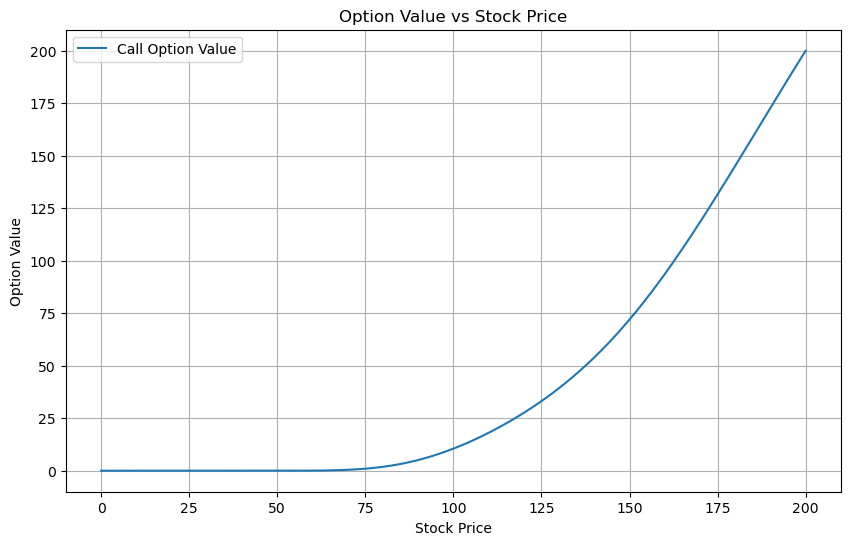

Call Option Price: 10.53


In [30]:
def black_scholes_findif(S_max, K, T, r, sigma, dx, dt):
    # Grid size
    N = int(S_max / dx) + 1  # Asset price steps
    M = int(T / dt) + 1  # Time steps
    
    # Grid for stock prices and option values
    S = np.linspace(0, S_max, N)
    V = np.maximum(S - K, 0)  # Intrinsic values for American Call
    V_new = np.zeros_like(V)

    # Coefficients for the finite difference method
    alpha = 0.5 * dt * (sigma**2 * np.arange(N)**2 - r * np.arange(N))
    beta = 1 - dt * (sigma**2 * np.arange(N)**2 + r)
    gamma = 0.5 * dt * (sigma**2 * np.arange(N)**2 + r * np.arange(N))

    # Solving the PDE
    for j in range(M-1):
        for i in range(1, N-1):
            V_new[i] = alpha[i] * V[i-1] + beta[i] * V[i] + gamma[i] * V[i+1]
        V_new[0] = 0  # Boundary condition at S=0 (call is worthless)
        V_new[-1] = S_max - K + (S_max - K) * np.exp(-r * dt * (M-j))  # Far boundary approximation
        
        # Ensure the condition: V = max(V, S - K)
        V = np.maximum(V_new, S - K)

    return S, V

# Parameters
S_max = 200    # Maximum stock price
K = 100        # Strike price
T = 1          # Time to maturity in years
r = 0.05       # Risk-free rate
sigma = 0.2    # Volatility
dx = 1.0       # Space step
dt = 0.0002     # Time step (CFL condition: dt < dx^2/(sigma^2*S_max^2))

# Compute the option prices
S, V = black_scholes_findif(S_max, K, T, r, sigma, dx, dt)

# Print results
plt.figure(figsize=(10, 6))
plt.plot(S, V, label="Call Option Value")
plt.title("Option Value vs Stock Price")
plt.xlabel("Stock Price")
plt.ylabel("Option Value")
plt.legend()
plt.grid(True)
plt.show()
print(f"Call Option Price: {V[S == 100][0]:.2f}")


Another approach is the "finite difference" method, where we can approximate the derivatives of the PDE with *finite differences*. 
As we see, this generates a price for all possible stock prices up to a given value, which in this case was chosen to be 200. 
This can be useful, as we now have a result for all possible *strike prices* (up to a given value). For this model, it is not computationally heave to calculate the option price, but for more elaborate models, it could be worthwhile to have prices stored if the model takes a long time to calculate the price.

## Empirical options pricing

While the model works great in theory, it needs to be compared to empirical data to determine its validity. For this, I wille be using a chain of options on the S&P-500 index with different strike prices, but all options have the same expiry date, 21/6, which means that they have 39 DTE (days to expiration). The options chosen are call options and since they are written on the S&P-500 index, they are considered to be quite liquid and the prices will therefore be accurate enough for testing purposes. 
When checking the models validity,I will be comparing the *implied volatility*. The IV is determined to be the volatility needed to put in to the formula to produce the price using the Black-Scholes model. As such, it can be seen as the inverse of the BS model (there does not exist a specific formula that takes price as input and volatility as output).



The optimal volatility is: 0.1242


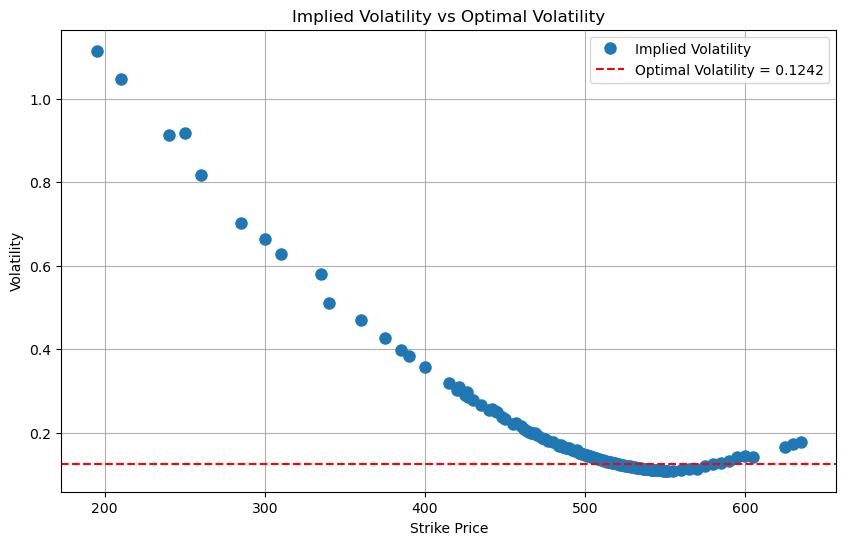

In [48]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

# Load the dataset
file_path = 'options_21-06.csv'
data = pd.read_csv(file_path)


# Error function
def error_function(sigma, S0, K, T, r, market_price):
    model_price = black_scholes_call(S0, K, T, r, sigma)
    return np.sum((model_price - market_price) ** 2)

# Optimization function
def find_optimal_volatility(data):
    S0 = 509  # Assuming all options have the same underlying price
    r = 0.05  # Assuming a single risk-free rate for all options
    T = 39/252  # Assuming all options have the same expiry
    
    
    K = data['Strike'].values
    market_prices = data['Midpoint'].values
    
    initial_guess = 0.2  # Initial guess for volatility
    result = minimize(error_function, initial_guess, args=(S0, K, T, r, market_prices), bounds=[(0.0001, 5.0)])
    
    return result.x[0]

# Find the optimal volatility
optimal_volatility = find_optimal_volatility(data)
print(f"The optimal volatility is: {optimal_volatility:.4f}")

data['IV'] = data['IV'].str.rstrip('%').astype('float') / 100.0

# Plot the implied volatilities and the optimal volatility
K = data['Strike'].values
implied_volatilities = data['IV'].values

plt.figure(figsize=(10, 6))
plt.plot(K, implied_volatilities, 'o', label='Implied Volatility', markersize=8)
plt.axhline(y=optimal_volatility, color='r', linestyle='--', label=f'Optimal Volatility = {optimal_volatility:.4f}')
plt.xlabel('Strike Price')
plt.ylabel('Volatility')
plt.title('Implied Volatility vs Optimal Volatility')
plt.legend()
plt.grid(True)
plt.show()


As it can be seen from the figure above, the Black-Scholes model actually does a rather poor job of recreating the implied volatilities observed in the market. The reason for this, is that Black-Scholes assumes constant volatility which is clearly not observed in the market. Options with a lower strike price are priced under an assumption of a higher volatility.

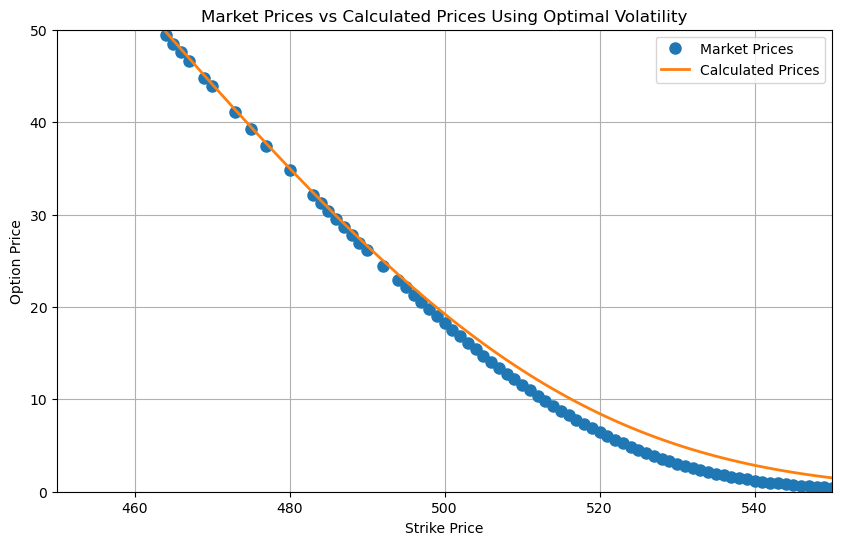

In [41]:
# Calculate option prices using the optimal volatility
S0 = 509
r = 0.05
T = 49/252
K = data['Strike'].values
market_prices = data['Midpoint'].values

calculated_prices = [black_scholes_call(S0, k, T, r, optimal_volatility) for k in K]

# Plot the market prices and calculated prices
plt.figure(figsize=(10, 6))
plt.plot(K, market_prices, 'o', label='Market Prices', markersize=8)
plt.plot(K, calculated_prices, '-', label='Calculated Prices', linewidth=2)
plt.xlim(450,550)
plt.ylim(0,50)
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Market Prices vs Calculated Prices Using Optimal Volatility')
plt.legend()
plt.grid(True)
plt.show()

When comparing the prices calculated by using the *optimal volatility* found with the actual market prices, it is also quite easy to see that the two do not align perfectly, but here it is not quite as easy to see the difference, which is why it is better to compare the volatilities. Another way to compare results of different levels of volatility would be to look at the error function used to find the optimal vol.

In [60]:
error_VIX = error_function(sigma=0.15,S0=509,K=data['Strike'].values,T=39/252,r=0.05,market_price=data['Midpoint'].values)
error_optimal = error_function(sigma=0.1242,S0=509,K=data['Strike'].values,T=39/252,r=0.05,market_price=data['Midpoint'].values)
print(error_VIX)
print(error_optimal)


236.89175669445584
46.14699017388277


Here we can see that when using the optimal volatility, we obtain an error function value of 46, compared to using the *VIX* (the CBOE Volatility index, a measure of the S&P-500 volatility), where we get an error value of 236, approximately 5 times as high. 

# Further analysis

An extension of the Black-Scholes model is the Heston model (1993). In this model, the volatility of the underlying asset is no longer assumed to be constant, but is instead assumed to follow a Cox-Ingersoll-Ross (CIR) process. For the sake of brevity, the model will not be derived here, but a good resource for this is Jim Gatheral (2006): *The Volatility surface - A practitioner's guide*. 

In the model, we assume that the stock price follow the stochastic differential equation:
$$dS_t=\mu S_tdt+sqrt{v_t}S_tdW_{1,t}$$
$$dv_t=\kappa(\theta-v_t)dt+\sigma\sqrt{v_t}dW_{2,t}$$
Where the two Wiener processes are correlated with $\rho$. $\kappa$ represents the speed of mean-reversion, $\theta$ is the long-run variance and $\sigma$ is the vol-of-vol.


The price of a call option in the model is given by:
$$C(x,v,t)=S_tP_1-Ke^{-r\tau}P_2$$
Where $P_1$ and $P_2$ represents the probability that the option expires *in-the-money (ITM)*.
The probabilities are risk-neutral.
We rewrite $S_t\rightarrow \ln S_t=x_t$. 

The two probabilities can be represented by an inverse Fourier transformation, given by:

$$P_j(x,v,\tau,K)=\frac{1}{2}+\frac{1}{\pi}\int_0^\infty Re\left(\frac{e^{-i\phi \ln K}f_j(x,v,\tau,\phi)}{i\phi}\right)d\phi$$
$$f_j(x,v,\tau;\phi)=e^{C(\tau;\phi)+D(\tau;\phi)v+i\phi x}$$
Where $i=\sqrt{-1}$, $\phi\in R$ and
$$C(\tau;\phi)=ri\phi\tau+\frac{a}{\sigma^2}\left((b_j-\rho\sigma i \phi-d)\tau-2\ln\left(\frac{1-ge^{dr}}{1-g}\right)\right)$$
$$D(\tau;\phi)=\frac{(b_j-\rho\sigma i\phi-d)(1-e^{-dr})}{\sigma^2(1-ge^{-dr})}$$
$$d=\sqrt{(b_j-\rho\sigma i \phi)^2-\sigma^2(2\phi u_ji-\phi^2)}$$
$$g=\frac{b_j-\rho\sigma i\phi-d}{b_j-\rho\sigma i\phi+d}$$
$$u_1=\frac{1}{2},\quad u_2=-\frac{1}{2},\quad a=\kappa\theta,\quad b_1=\kappa-\rho\sigma,\quad b_2=\kappa$$


There are several ways to go about using the Heston model.
One way is to calibrate the model using a large dataset of options prices, in order to calibrate the parameters of the model. This is usually required since the model's parameters cannot be directly observed in the market.

Another method is to use Monte Carlo simulations to approximate the price. But this requires knowledge about the parameters.

In [61]:
import scipy.integrate as integrate
import cmath

def heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r):
    """ Returns the characteristic function for the Heston model. """
    i = complex(0, 1)
    d = cmath.sqrt((rho * sigma * i * u - kappa)**2 + (sigma**2) * (i * u + u**2))
    g = (kappa - rho * sigma * i * u - d) / (kappa - rho * sigma * i * u + d)
    
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u - d) * T - 2 * cmath.log((1 - g * cmath.exp(-d * T))/(1 - g)))
    D = (kappa - rho * sigma * i * u - d) / sigma**2 * ((1 - cmath.exp(-d * T)) / (1 - g * cmath.exp(-d * T)))
    
    return cmath.exp(C + D * v0 + i * u * cmath.log(S0))

def heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_=0):
    " Calculates the Heston model price of a call option. "
    i = complex(0, 1)
    integrand = lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u - i, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u * heston_char_function(-i, T, S0, v0, kappa, theta, sigma, rho, r))).real
    integral = integrate.quad(integrand, 0, np.inf)[0]
    return S0 * (0.5 + integral/np.pi) - K * np.exp(-r * T) * (0.5 + integrate.quad(lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u)).real, 0, np.inf)[0] / np.pi)

# parameters guesses
S0 = 509     # asset price
K = 509      # Strike price
T = 0.154        # Time to maturity
r = 0.05     # Risk-free rate
kappa = 0.33  # Rate of mean reversion
theta = 0.014  # Long-term variance
sigma = 0.49  # vol-of-vol
rho = -0.62   # Correlation
v0 = 0.0028    # Initial variance

# Calculate the call price
price = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
print("The price of the European call option is:", price)

The price of the European call option is: 6.097918023708701


First, I implement the Heston model and its functions, and use it to price an option with the parameters specified above as a test, to check that it actually works. This result will also be used later to compare to the results given by Monte Carlo simulations. 

But now, to use the Heston model it is necessary to calibrate the model. This is **very** computationally heavy, since it is a 5-dimensional problem that must be solved, and even the calculation for a single price takes some time since the program must deal with both integrals and complex numbers.

**WARNING: It takes approximately 25 minutes for this calibration to run**

Params: [ 1.43    0.14    0.3    -0.62    0.0028], SSE: 190.13662473077915
Params: [ 1.43001  0.14     0.3     -0.62     0.0028 ], SSE: 190.15802744496173
Params: [ 1.43     0.14001  0.3     -0.62     0.0028 ], SSE: 190.3743841441097
Params: [ 1.43     0.14     0.30001 -0.62     0.0028 ], SSE: 190.11450025040713
Params: [ 1.43     0.14     0.3     -0.61999  0.0028 ], SSE: 190.14711060061592
Params: [ 1.43     0.14     0.3     -0.62     0.00281], SSE: 192.05833211970878
Params: [ 0.001  0.001  1.    -0.99   0.001], SSE: 151106.89099098847
Params: [ 0.00101  0.001    1.      -0.99     0.001  ], SSE: 151107.77442741382
Params: [ 0.001    0.00101  1.      -0.99     0.001  ], SSE: 151107.7689301006
Params: [ 0.001    0.001    0.99999 -0.99     0.001  ], SSE: 151112.00027481277
Params: [ 0.001    0.001    1.      -0.98999  0.001  ], SSE: 151065.3662622066
Params: [ 0.001    0.001    1.      -0.99     0.00101], SSE: 116950.93698948545
Params: [ 0.94490038  0.09281396  0.53762753 -0.74560312  

C:\Users\victo\AppData\Local\Temp\ipykernel_6064\4217433874.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral1 = quad(integrand1, 0, np.inf)[0]
C:\Users\victo\AppData\Local\Temp\ipykernel_6064\4217433874.py:43: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calli

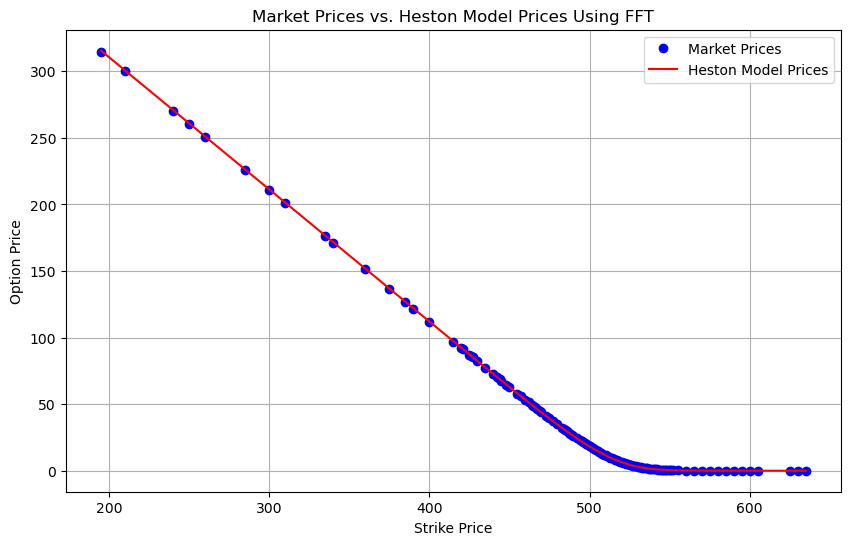

In [77]:
import numpy as np
import pandas as pd
import cmath
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
import warnings

# Load the dataset
data = pd.read_csv('options_21-06.csv')
strikes = data['Strike'].values
market_prices = data['Midpoint'].values

# Calculate the spread
bid_prices = data['Bid'].values
ask_prices = data['Ask'].values
spreads = ask_prices - bid_prices

# Fixed values for underlying price, risk-free rate, and maturity
S0 = 509  # Example value, replace with actual underlying price
r = 0.05  # Example value, replace with actual risk-free rate
tau = 0.154  # Example value, replace with actual maturity (in years)

# Define the Heston characteristic function
def heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r):
    i = complex(0, 1)
    d = cmath.sqrt((rho * sigma * i * u - kappa)**2 + (sigma**2) * (i * u + u**2))
    g = (kappa - rho * sigma * i * u - d) / (kappa - rho * sigma * i * u + d)
    
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u - d) * T - 2 * cmath.log((1 - g * cmath.exp(-d * T))/(1 - g)))
    D = (kappa - rho * sigma * i * u - d) / sigma**2 * ((1 - cmath.exp(-d * T)) / (1 - g * cmath.exp(-d * T)))
    
    return cmath.exp(C + D * v0 + i * u * cmath.log(S0))

# Define the Heston model call price function
def heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_=0):
    i = complex(0, 1)
    
    integrand1 = lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u - i, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u * heston_char_function(-i, T, S0, v0, kappa, theta, sigma, rho, r))).real
    integral1 = quad(integrand1, 0, np.inf)[0]
    
    integrand2 = lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u)).real
    integral2 = quad(integrand2, 0, np.inf)[0]
    
    return S0 * (0.5 + integral1 / np.pi) - K * np.exp(-r * T) * (0.5 + integral2 / np.pi)

# Objective function to minimize (weighted sum of squared errors)
def objective(params):
    kappa, theta, sigma, rho, v0 = params
    model_prices = np.array([heston_call_price(S0, K, tau, r, kappa, theta, sigma, rho, v0) for K in strikes])
    weights = 1 / np.maximum(spreads, 1e-10)  # Prevent division by zero
    sse = np.sum(weights * (model_prices - market_prices) ** 2)
    print(f"Params: {params}, SSE: {sse}")
    return sse

# Initial guess for the parameters
initial_guess = [1.43, 0.14, 0.3, -0.62, 0.0028]

# Measure the calibration time
import time
start_time = time.time()

# Set the options for the optimizer, including the minimal step size
options = {
    'disp': True,       # Display intermediate steps
    'eps': 1e-5,        # Set the minimal step size for numerical approximation
    'ftol': 1e-9,       # Function tolerance for convergence
    'gtol': 1e-5        # Gradient tolerance for convergence
}

# Calibrate the Heston model
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=[(0.001, 10), (0.001, 1), (0.001, 1), (-0.99, 0.99), (0.001, 1)], options=options)

end_time = time.time()
calibration_time = end_time - start_time

# Extract the calibrated parameters
if result.success:
    kappa, theta, sigma, rho, v0 = result.x
    print(f"Calibrated parameters:\nkappa: {kappa}\ntheta: {theta}\nsigma: {sigma}\nrho: {rho}\nv0: {v0}")
else:
    print("Optimization failed.")
    kappa, theta, sigma, rho, v0 = initial_guess

print(f"Calibration took {calibration_time:.2f} seconds")

# Calculate model prices using the calibrated parameters
model_prices = np.array([heston_call_price(S0, K, tau, r, kappa, theta, sigma, rho, v0) for K in strikes])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(strikes, market_prices, 'bo', label='Market Prices')
plt.plot(strikes, model_prices, 'r-', label='Heston Model Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Market Prices vs. Heston Model Prices')
plt.legend()
plt.grid(True)
plt.show()


As we can see, the calibration has now ended and it produces results which match the market prices very well. While the error function is different than the one used to calibrate the Black-Scholes model (here it is a weighted error function), we can still see that it is approx. 6.6 compared to the BS model which was 46.
By zooming in on the graph, we can also compare the results visually with Black-Scholes to see that it is clearly performing better.

C:\Users\victo\AppData\Local\Temp\ipykernel_6064\3079699363.py:44: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral1 = quad(integrand1, 0, np.inf)[0]
C:\Users\victo\AppData\Local\Temp\ipykernel_6064\3079699363.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calli

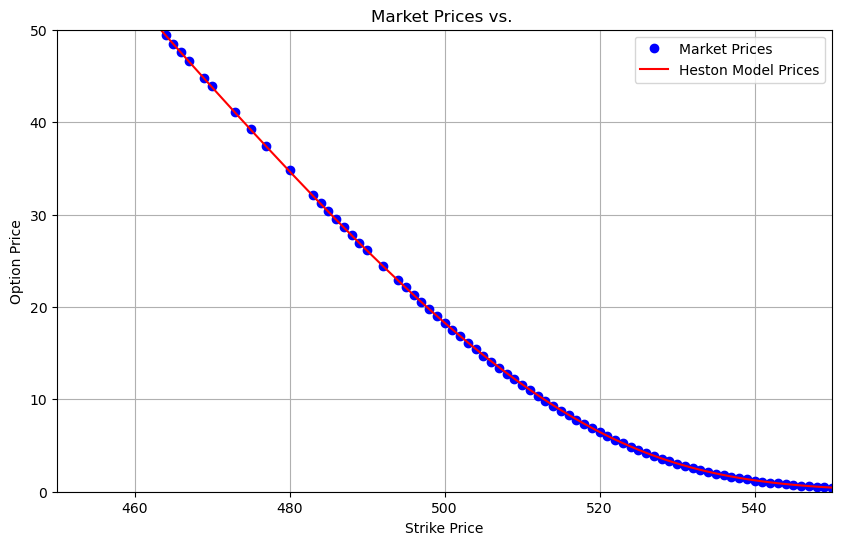

In [88]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from functools import partial
import matplotlib.pyplot as plt
import warnings

# Load the dataset
data = pd.read_csv('options_21-06.csv')
strikes = data['Strike'].values
market_prices = data['Midpoint'].values

# Fixed values for underlying price, risk-free rate, and maturity
S0 = 509  # Example value, replace with actual underlying price
r = 0.0526  # Example value, replace with actual risk-free rate
tau = 39/252  # Example value, replace with actual maturity (in years)

# Chosen values for the Heston model parameters
S0 = 509     # asset price
T = 0.154        # Time to maturity
r = 0.05     # Risk-free rate
kappa = 1.1604333246796712
theta = 0.15598790819443784
sigma = 0.4918022078887363
rho = -0.6094460562477696
v0 = 0.004388695626548049

# Define the Heston characteristic function
def heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r):
    i = complex(0, 1)
    d = cmath.sqrt((rho * sigma * i * u - kappa)**2 + (sigma**2) * (i * u + u**2))
    g = (kappa - rho * sigma * i * u - d) / (kappa - rho * sigma * i * u + d)
    
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u - d) * T - 2 * cmath.log((1 - g * cmath.exp(-d * T))/(1 - g)))
    D = (kappa - rho * sigma * i * u - d) / sigma**2 * ((1 - cmath.exp(-d * T)) / (1 - g * cmath.exp(-d * T)))
    
    return cmath.exp(C + D * v0 + i * u * cmath.log(S0))

# Define the Heston model call price function
def heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_=0):
    i = complex(0, 1)
    
    integrand1 = lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u - i, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u * heston_char_function(-i, T, S0, v0, kappa, theta, sigma, rho, r))).real
    integral1 = quad(integrand1, 0, np.inf)[0]
    
    integrand2 = lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u)).real
    integral2 = quad(integrand2, 0, np.inf)[0]
    
    return S0 * (0.5 + integral1 / np.pi) - K * np.exp(-r * T) * (0.5 + integral2 / np.pi)

# Calculate model prices using the chosen parameters
models_prices = np.array([heston_call_price(S0, K, tau, r, kappa, theta, sigma, rho, v0) for K in strikes])

def objective(params):
    kappa, theta, sigma, rho, v0 = params
    model_prices = np.array([heston_call_price(S0, K, tau, r, kappa, theta, sigma, rho, v0) for K in strikes])
    weights = 1 / np.maximum(spreads, 1e-10)  # Prevent division by zero
    sse = np.sum(weights * (model_prices - market_prices) ** 2)
    print(f"Params: {params}, SSE: {sse}")
    return sse

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(strikes, market_prices, 'bo', label='Market Prices')
plt.plot(strikes, models_prices, 'r-', label='Heston Model Prices')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Market Prices vs. ')
plt.legend()
plt.xlim(450, 550)
plt.ylim(0, 50)
plt.grid(True)
plt.show()


Now, I will look at whether Monte Carlo simulations are a viable alternative to the analytical results found above.
Naturally, these simulations can only work once the parameters have been calibrated, but it is nonetheless worthwhile to look at, since it is a different approach to the problem.

The price of the European call option is: 9.77379032877068


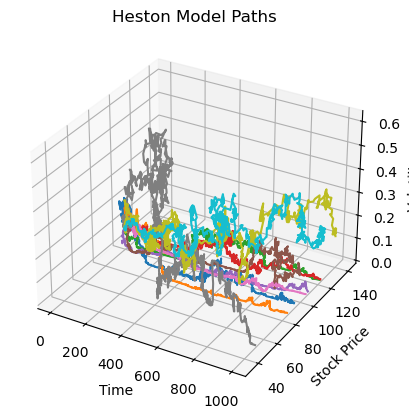

Option value:  10.985593177254822


In [89]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm


def heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r):
    """ Returns the characteristic function for the Heston model. """
    i = complex(0, 1)
    d = cmath.sqrt((rho * sigma * i * u - kappa)**2 + (sigma**2) * (i * u + u**2))
    g = (kappa - rho * sigma * i * u - d) / (kappa - rho * sigma * i * u + d)
    
    C = r * i * u * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * u - d) * T - 2 * cmath.log((1 - g * cmath.exp(-d * T))/(1 - g)))
    D = (kappa - rho * sigma * i * u - d) / sigma**2 * ((1 - cmath.exp(-d * T)) / (1 - g * cmath.exp(-d * T)))
    
    return cmath.exp(C + D * v0 + i * u * cmath.log(S0))

def heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lambda_=0):
    " Calculates the Heston model price of a call option. "
    i = complex(0, 1)
    integrand = lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u - i, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u * heston_char_function(-i, T, S0, v0, kappa, theta, sigma, rho, r))).real
    integral = integrate.quad(integrand, 0, np.inf)[0]
    return S0 * (0.5 + integral/np.pi) - K * np.exp(-r * T) * (0.5 + integrate.quad(lambda u: (cmath.exp(-i * u * np.log(K)) * heston_char_function(u, T, S0, v0, kappa, theta, sigma, rho, r) / (i * u)).real, 0, np.inf)[0] / np.pi)

# parameters guesses
S0 = 100     # asset price
K = 100      # Strike price
T = 1        # Time to maturity
r = 0     # Risk-free rate
kappa = 1.0  # Rate of mean reversion
theta = 0.09  # Long-term variance
sigma = 1  # vol-of-vol
rho = -0.3   # Correlation
v0 = 0.09    # Initial variance

# Calculate the call price
price = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
print("The price of the European call option is:", price)



# Define parameters

N = 1000  # number of simulation paths
M = 1000  # number of time steps
dt = T / M  # time step size

# Define the function for the Heston model
def heston(s0, v0, kappa, theta, sigma, rho, r, T, M, N):
    # Initialize arrays
    S = np.zeros((M + 1, N))
    V = np.zeros((M + 1, N))
    S[0, :] = s0
    V[0, :] = v0

    # Generate correlated Brownian motions
    z1 = np.random.normal(size=(M, N))
    z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=(M, N))

    # Generate stock price and volatility paths
    for t in range(1, M + 1):
        # Calculate the drift and volatility
        drift = r * S[t - 1, :]
        vol = np.sqrt(V[t - 1, :])

        # Update the stock price and volatility
        S[t, :] = S[t - 1, :] * np.exp((drift - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z1[t - 1, :])
        V[t, :] = np.maximum(
            0.0, V[t - 1, :] + kappa * (theta - V[t - 1, :]) * dt + sigma * np.sqrt(V[t - 1, :]) * np.sqrt(dt) * z2[t - 1, :]
        )

    # Calculate the option payoff at maturity
    payoff = np.maximum(S[-1, :] - K, 0)

    # Calculate the option value using the LSM method
    for t in range(M - 1, 0, -1):
        # Calculate the cash flows and exercise values
        cash_flows = np.zeros(N)
        exercise_values = np.zeros(N)
        for i in range(N):
            if payoff[i] > 0:
                cash_flows[i] = payoff[i] * np.exp(-r * (T - t) / (M - t))
                exercise_values[i] = payoff[i]

        # Calculate the continuation values
        x = np.log(S[t, :] / K)
        y = np.sqrt(V[t, :])
        X = np.column_stack((np.ones(N), x, x ** 2, x ** 3, x ** 4))
        X_inv = np.linalg.inv(np.dot(X.T, X))
        beta = np.dot(X_inv, np.dot(X.T, cash_flows))
        continuation_values = np.dot(X, beta)

        # Determine the optimal exercise policy
        early_exercise = exercise_values > continuation_values
        payoff[early_exercise] = exercise_values[early_exercise]

    # Calculate the option value using Monte Carlo simulation
    discount_factor = np.exp(-r * T)
    option_value = discount_factor * np.mean(payoff)

    return option_value

# Value the American-style option using the Heston model and Monte Carlo simulation
option_value = heston(S0, v0, kappa, theta, sigma, rho, r, T, M, N)

# Generate a 4D graph of the Heston model paths
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Heston Model Paths")
ax.set_xlabel("Time")
ax.set_ylabel("Stock Price")
ax.set_zlabel("Volatility")
S = np.zeros((M + 1, N))
V = np.zeros((M + 1, N))
S[0, :] = S0
V[0, :] = v0
z1 = np.random.normal(size=(M, N))
z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=(M, N))

# Generate stock price and volatility paths
for t in range(1, M + 1):
    # Calculate the drift and volatility
    drift = r * S[t - 1, :]
    vol = np.sqrt(V[t - 1, :])

    # Update the stock price and volatility
    S[t, :] = S[t - 1, :] * np.exp((drift - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z1[t - 1, :])
    V[t, :] = np.maximum(
        0.0, V[t - 1, :] + kappa * (theta - V[t - 1, :]) * dt + sigma * np.sqrt(V[t - 1, :]) * np.sqrt(dt) * z2[t - 1, :]
    )

for i in range(10):
    ax.plot(np.arange(M + 1), S[:, i], V[:, i])
plt.show()

# Print information about the simulation
print("Option value: ", option_value)

| N\M     | 10             | 100             | 1.000           | 10.000          |
| ------- | -------------- | --------------- | --------------- | --------------- |
| 100     | 2.81 (0.3 sec) | 1.16 (0.5 sec)  | 1.75 (0.7 sec)  | 1.82 (3.3 sec)  |
| 1.000   | 2.18 (0.3 sec) | 1.11 (0.5 sec)  | 0.27 (2.9 sec)  | 0.73 (25.9 sec) |
| 10.000  | 1.70 (0.5 sec) | 0.82 (2.8 sec)  | 0.40 (27.5 sec) | 0.54 (403 sec)  |
| 100.000 | 1.87 (2.9 sec) | 0.78 (28.3 sec) | 0.41 (352 sec)  | X               |

These are the results from several different Monte Carlo simulations. The first value is the absolute price error, and the second value is the runtime in seconds. Of course, the results may vary if ran again.

As we can see, the performance of the simulations gets better the more simulation paths are used and the more discrete time intervals used.

We can clearly see that the analytical version performs better, both i terms of being closer to the actual price, but it is also faster (once the model has been calibrated). Using Monte Carlo simulations are therefore not advisable for pricing European options. 

It is, however, a viable method if there does not exist a closed form solution to the price of an option. This is typically the case for more exotic options, and is used extensively in the financial industry, especially for pricing path-dependent options.

# Conclusion

In this project, the Black-Scholes model has been derived and explored. The model has been solved analytically, and the option price has also been approximated using both MC simulations and *finite differences*. 

The Heston model has also been evaluated, and this option price has been calculated analytically and the model has been calibrated.
Monte Carlo simulations have also been used to calculate options prices, and it has been observed that while these do not perform as well as the analytical results, it may be a viable method for pricing other options.

We can conclude that the Black-Scholes model severely underperforms the Heston model, but the tradeoff of using a more sophisticated model comes at a cost of higher complexity and a significantly higher computational cost.

A possible extension for this analysis would be to find ways to make the calibration faster. A possible way for this would be to use the *Fast Fourier Transform (FFT)*. By using this algo, I estimate that a similar calibration will take two maginitudes fewer minutes/seconds.